# Visualizing Large Data

In this notebook, we will walk through how to use H2O-3 to visualize large data.  We will perform the following steps:

* use H2O-3 to plot histograms
* use H2O-3 to calculate custom aggregations and plot with matplotlib
* use H2O-3 to reduce the size of the data using the [H2O Aggregator](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/aggregator.html) function and graph the aggregated data

In [73]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "12.0.2" 2019-07-16; Java(TM) SE Runtime Environment (build 12.0.2+10); Java HotSpot(TM) 64-Bit Server VM (build 12.0.2+10, mixed mode, sharing)
  Starting server from /Users/megankurka/env2/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/fk/z2fjbsq163scfcsq9fhsw7r00000gn/T/tmp4vaeleld
  JVM stdout: /var/folders/fk/z2fjbsq163scfcsq9fhsw7r00000gn/T/tmp4vaeleld/h2o_megankurka_started_from_python.out
  JVM stderr: /var/folders/fk/z2fjbsq163scfcsq9fhsw7r00000gn/T/tmp4vaeleld/h2o_megankurka_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.4
H2O cluster version age:,1 month and 29 days
H2O cluster name:,H2O_from_python_megankurka_mt3f3n
H2O cluster total nodes:,1
H2O cluster free memory:,4 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


## Create Histograms

We will import our airlines data which is a little over 5 million records and create histograms from some of the numeric columns.

Note: to have the graphs render in Jupyter notebook, add to a cell: `%matplotlib inline`.

In [74]:
airlines = h2o.import_file(
  path="https://s3.amazonaws.com/h2o-public-test-data/bigdata/laptop/airlines_all.05p.csv"
)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [75]:
airlines.dim

[5834763, 31]

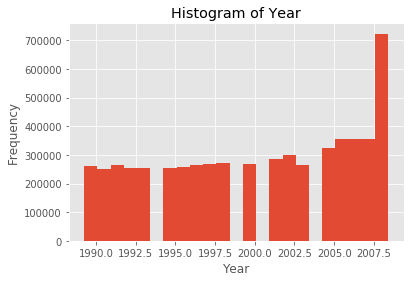

In [76]:
%matplotlib inline
airlines["Year"].hist()

We can see from histograms that we have some years with no data.

## Visualize Custom Aggregations

Now we will create some aggregations of the data using h2o's `group_by` function and visualize using open source plotting libraries like matplotlib.

We will start by calculating the percentage of delayed flights by month.

In [77]:
delays_by_month = airlines.group_by("Month").mean("IsDepDelayed").get_frame()
delays_by_month

Month,mean_IsDepDelayed
1,0.446466
2,0.442427
3,0.439182
4,0.390929
5,0.38515
6,0.457583
7,0.446191
8,0.436933
9,0.353932
10,0.379365


We have taken our 5 million row dataset and reduced it to 12 rows which can be easily visualized by any plotting library of choice.  We will use matplotlib.

From the graph, we can see that December has the greatest percentage of delays.

In [78]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

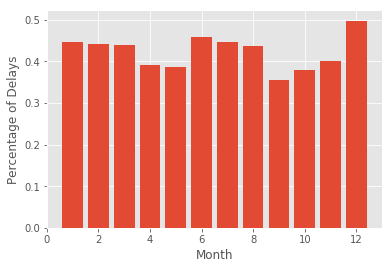

In [79]:
plot_data = delays_by_month.as_data_frame(use_pandas=True)
plt.bar(plot_data.Month, plot_data.mean_IsDepDelayed)
plt.ylabel("Percentage of Delays")
plt.xlabel("Month")
plt.show()

## Reduce the Size of the Data using H2O-3's Aggregator

There may be cases where we which to visualize individual points, not aggregations.  For most datasets, however, these scatter plots will have too many points causing the plot to be unreadable.

In this case, we can use [H2O-3's Aggregator](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/aggregator.html) to reduce the size of the data.  This method is preferred to random sampling because the aggregator will maintain the shape of the data.  Random sampling will often cause outliers to be accidentally removed.

We will ask the aggregator to reduce the size of the data to 500 records.

In [80]:
from h2o.estimators.aggregator import H2OAggregatorEstimator


# Build an aggregated frame with around 500 records
agg = H2OAggregatorEstimator(target_num_exemplars = 1000)
agg.train(training_frame=airlines)

# Use the aggregated model to create a new dataframe using aggregated_frame
small_airlines = agg.aggregated_frame

aggregator Model Build progress: |████████████████████████████████████████| 100%


In [81]:
small_airlines.dim

[979, 32]

We now have a dataset that can easily be converted to pandas and graphed by any plotting library of choice.  We will again use matplotlib.

We will plot the departure time and arrival time.

In [82]:
airlines

Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,IsArrDelayed,IsDepDelayed
1988,1,9,6,1348,1331,1458,1435,PI,942,nan,70,64,nan,23,17,SYR,BWI,273,nan,nan,0,nan,0,nan,nan,nan,nan,nan,YES,YES
1988,1,29,5,1339,1331,1442,1435,PI,942,nan,63,64,nan,7,8,SYR,BWI,273,nan,nan,0,nan,0,nan,nan,nan,nan,nan,YES,YES
1988,1,23,6,950,950,1041,1050,PI,943,nan,51,60,nan,-9,0,LGA,SYR,198,nan,nan,0,nan,0,nan,nan,nan,nan,nan,NO,NO
1988,1,18,1,1124,1110,1213,1145,PI,943,nan,49,35,nan,28,14,SYR,BUF,134,nan,nan,0,nan,0,nan,nan,nan,nan,nan,YES,YES
1988,1,10,7,1503,1500,1602,1550,PI,944,nan,59,50,nan,12,3,JFK,UCA,191,nan,nan,0,nan,0,nan,nan,nan,nan,nan,YES,YES
1988,1,30,6,1500,1500,1558,1550,PI,944,nan,58,50,nan,8,0,JFK,UCA,191,nan,nan,0,nan,0,nan,nan,nan,nan,nan,YES,NO
1988,1,20,3,1750,1705,1900,1810,PI,944,nan,70,65,nan,50,45,SYR,BOS,264,nan,nan,0,nan,0,nan,nan,nan,nan,nan,YES,YES
1988,1,10,7,1616,1610,1632,1630,PI,944,nan,16,20,nan,2,6,UCA,SYR,37,nan,nan,0,nan,0,nan,nan,nan,nan,nan,YES,YES
1988,1,30,6,1610,1610,1627,1630,PI,944,nan,17,20,nan,-3,0,UCA,SYR,37,nan,nan,0,nan,0,nan,nan,nan,nan,nan,NO,NO
1988,1,22,5,2026,2031,2135,2142,PI,945,nan,69,71,nan,-7,-5,SYR,DCA,298,nan,nan,0,nan,0,nan,nan,nan,nan,nan,NO,NO


In [83]:
small_airlines_pd = small_airlines.as_data_frame(use_pandas = True)

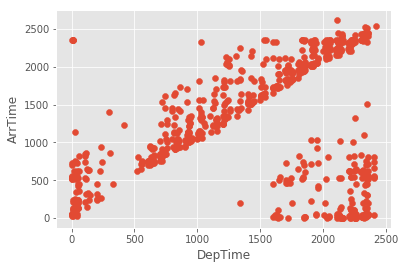

In [84]:
plt.scatter(small_airlines_pd.DepTime, small_airlines_pd.ArrTime)
plt.xlabel("DepTime")
plt.ylabel("ArrTime")
plt.show()

As a comparison, we try graphing the whole dataset's departure time and arrival time.

We can see that this step takes much longer and produces a lot of overlapping points which makes it hard to see the general trend in the data.

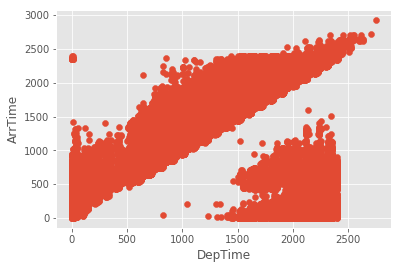

In [85]:
big_airlines_pd = airlines.as_data_frame(use_pandas = True)

plt.scatter(big_airlines_pd.DepTime, big_airlines_pd.ArrTime)
plt.xlabel("DepTime")
plt.ylabel("ArrTime")
plt.show()

In [86]:
h2o.cluster().shutdown()

H2O session _sid_ab93 closed.
